Задача "Модератор Одноклассников"

Формулировка задания

В социальной сети Одноклассники есть платформа для разметки данных. На ней пользователям была дана задача выделить прямоугольником заданный объект на фотографии. По ответам людей нужно восстановить истинное положение объекта.

На входе вы получите краудсорсинговую разметку и данные в виде любимых всеми табличек, бейзлайн и тестовый сабмит с нулями. 

В ответ вы должны будете прислать просто файл (такой же, как и sample_submit) с вашими предсказаниями.

Предварительные результаты валидируются на 50% выборки. В день можно загружать не более 5 решений.

Для оценки решения будет использоваться метрика mIOU (mean intersection over union). Если еще не сталкивались с данной метрикой, то рекомендуем прочитать о ней [статью](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/).

https://mlbootcamp.ru/round/21/tasks/

In [13]:
import os
import json
from tqdm import tqdm_notebook
import itertools
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [14]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [15]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['axes.edgecolor']='black'
matplotlib.rcParams['xtick.color']='black'
matplotlib.rcParams['ytick.color']='black'
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['black', "red", "blue", "limegreen", 'purple', 'yellow', 'orange', 'green'])
matplotlib.rcParams['axes.linewidth']=1.3
matplotlib.rcParams['text.color']='black'

Прописываем путь до папки с данными

In [16]:
FILE_PATH = '/Users/anton.andreytsev/competitions/data/moderator_odnoklassnikov_data'

Загружаем данные

In [17]:
X_train = pd.read_csv(os.path.join(FILE_PATH, 'train_data.csv'))
y_train = pd.read_csv(os.path.join(FILE_PATH, 'train_answers.csv'))
X_test = pd.read_csv(os.path.join(FILE_PATH, 'test_data.csv'))
target_cols = ['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']

In [18]:
X_train.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819


In [19]:
X_test.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1581,34804,86,640,242,743
1,1351,34804,85,655,273,766
2,161,34804,85,648,268,748
3,313,5704,32,618,647,1268
4,1097,5704,25,620,602,1242


In [20]:
y_train.head()

,itemId,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,5,198,827,649,1340
1,10,26,605,433,847
2,13,233,698,622,920
3,30,61,368,329,530
4,32,30,536,328,813


Объединим треин и тест в один датафрейм

In [21]:
dat = pd.concat([pd.merge(X_train, y_train, on='itemId'), X_test], sort=False)
tr_indexes = np.arange(X_train.shape[0])
te_indexes = np.arange(X_test.shape[0]) + X_train.shape[0]
dat.index = range(dat.shape[0])
dat.shape

(8952, 10)

Убедимся, что в треине нет пропусков

In [22]:
dat.loc[tr_indexes].isnull().sum()

userId       0
itemId       0
Xmin         0
Ymin         0
Xmax         0
Ymax         0
Xmin_true    0
Ymin_true    0
Xmax_true    0
Ymax_true    0
dtype: int64

В тесте как и ожидается пропуски только в таргете

In [23]:
dat.loc[te_indexes].isnull().sum()

userId          0
itemId          0
Xmin            0
Ymin            0
Xmax            0
Ymax            0
Xmin_true    3615
Ymin_true    3615
Xmax_true    3615
Ymax_true    3615
dtype: int64

Реализуем подсчёт метрики

In [24]:
def iou_metric(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

def iou_metric_matrix(A, B):
    result_ = []
    for i in range(A.shape[0]):
        result_.append(iou_metric(A[i], B[i]))
    return np.array(result_)

Реализуем отрисовку прямоугольника по координатам

In [25]:
def plot_rectangle(list_of_coords, label=None, color='blue'):
    x_lower, y_lower, x_upper, y_upper = list_of_coords
    plt.plot([x_lower, x_lower], [y_lower, y_upper], color=color, linewidth=3, label=label)
    plt.plot([x_upper, x_upper], [y_lower, y_upper], color=color, linewidth=3)
    plt.plot([x_lower, x_upper], [y_lower, y_lower], color=color, linewidth=3)
    plt.plot([x_lower, x_upper], [y_upper, y_upper], color=color, linewidth=3)
    if label is not None:
        plt.legend(fontsize=15);

Пример

iou_metric: 0.4558162755866201


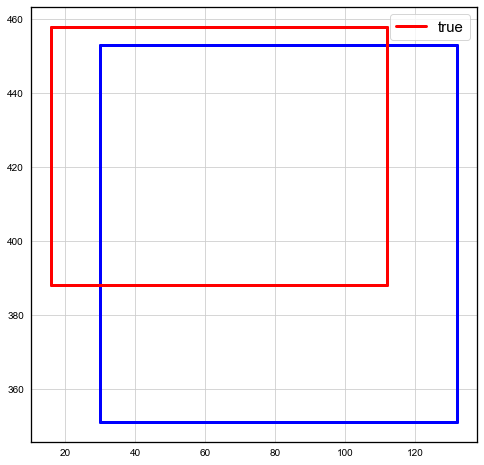

In [26]:
k = np.random.randint(dat.loc[tr_indexes].shape[0])
print('iou_metric:', iou_metric([dat.Xmin[k], dat.Ymin[k], dat.Xmax[k], dat.Ymax[k]], 
                 [dat.Xmin_true[k], dat.Ymin_true[k], dat.Xmax_true[k], dat.Ymax_true[k]]))
plot_rectangle([dat.Xmin[k], dat.Ymin[k], dat.Xmax[k], dat.Ymax[k]])
plot_rectangle([dat.Xmin_true[k], dat.Ymin_true[k], dat.Xmax_true[k], dat.Ymax_true[k]], color='red', label='true')

---
### Генерация признаков
---

Подсчитаем метрику для треиновых объектов


In [27]:
dat['iou'] = np.nan
metric_ = []
for i in tqdm_notebook(range(len(tr_indexes))):
    metric_.append(iou_metric([dat.Xmin[tr_indexes[i]], dat.Ymin[tr_indexes[i]], dat.Xmax[tr_indexes[i]], dat.Ymax[tr_indexes[i]]], 
                                        [dat.Xmin_true[tr_indexes[i]], dat.Ymin_true[tr_indexes[i]], dat.Xmax_true[tr_indexes[i]],
                                         dat.Ymax_true[tr_indexes[i]]]))
dat.iou[tr_indexes] = metric_

Добавим для каждого уникального userId добавим описательные статистики по таргету


In [28]:
descr_by_userid_df = dat.loc[tr_indexes].groupby(['userId'])['iou'].describe().reset_index().interpolate('linear')
dict_of_dicts = {}
for col in tqdm_notebook(descr_by_userid_df.columns[1:]):
    dict_of_dicts.update({col: dict(zip(descr_by_userid_df['userId'], descr_by_userid_df[col]))})

for key in dict_of_dicts:
    dat['userid_target_' + key.replace('%', '')] = dat.userId.map(dict_of_dicts[key])
# Для юзеров, которых не было в обучении интерполируем признаки    
dat[dat.columns.difference(['Xmin_true',
       'Ymin_true', 'Xmax_true', 'Ymax_true', 'iou'])] = dat[dat.columns.difference(['Xmin_true',
       'Ymin_true', 'Xmax_true', 'Ymax_true', 'iou'])].interpolate('linear')

Составим user_item_array матрицу


In [29]:
da = dat.loc[tr_indexes]
unq_items = np.unique(da.itemId)
unq_users = np.unique(da.userId)
items_dict = dict(zip(unq_items, range(len(unq_items))))
users_dict = dict(zip(unq_users, range(len(unq_users))))
items_dict_re = {x: y for y, x in items_dict.items()}
users_dict_re = {x: y for y, x in users_dict.items()}
user_item_array = np.zeros((unq_users.shape[0], unq_items.shape[0]))
for user in tqdm_notebook(unq_users):
    local_unq_items = np.unique(da.itemId[da.userId == user])
    for item in local_unq_items:
        user_item_array[users_dict[user], items_dict[item]] = da.iou[(da.userId == user)&(da.itemId == item)].mean()


In [30]:
dat['horizontal_edge_len'] = dat['Xmax'] - dat['Xmin']
dat['vertical_edge_len'] = dat['Ymax'] - dat['Ymin']
dat['horizontal_edge_len_true'] = dat['Xmax_true'] - dat['Xmin_true']
dat['vertical_edge_len_true'] = dat['Ymax_true'] - dat['Ymin_true']
dat['diagonal_len'] = np.sqrt(dat['vertical_edge_len']**2 + dat['horizontal_edge_len']**2)

Составим простой рейтинг пользователя: его средний скор и стандартное отклонение его скора


In [31]:
user_mean_iou_dict = dict(zip(list(da.userId.value_counts().keys()), 
                              [score[score > 0].mean() for score in user_item_array]))
user_std_iou_dict = dict(zip(list(da.userId.value_counts().keys()), 
                              [score[score > 0].std() for score in user_item_array]))

dat['mean_iou'] = np.nan
dat['std_iou'] = np.nan
dat['mean_iou'] = dat.userId.map(user_mean_iou_dict)
dat['std_iou'] = dat.userId.map(user_std_iou_dict)

Добавим user_item матрицу к признаковой матрице

In [214]:
user_item_to_df = np.zeros((dat.userId.shape[0], user_item_array.shape[1]))
for i, user in enumerate(dat.userId):
    if user in users_dict:
        user_item_to_df[i] = user_item_array[users_dict[user]]
dat = pd.concat([dat, _], axis=1)

---
### EDA
---

Посмотрим на распределение числа уникальных значений userId

In [32]:
pd.Series(dat.userId[tr_indexes].value_counts().values).describe()

count    1357.000000
mean        3.932940
std         5.549515
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        79.000000
dtype: float64

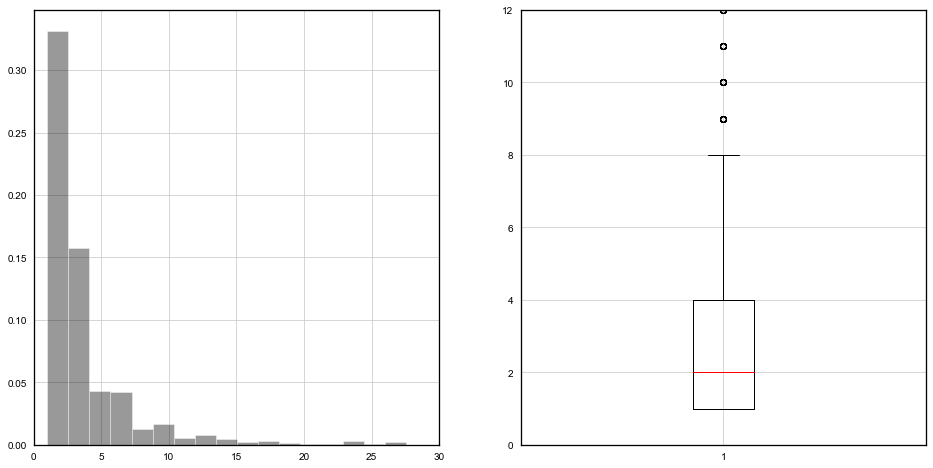

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.distplot(dat.userId[tr_indexes].value_counts().values, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_xlim(0, 30);
ax[1].boxplot(dat.userId[tr_indexes].value_counts().values);
plt.ylim(0, 12);

Есть ли новые юзеры в тесте

In [34]:
new_users = np.array(list(set(dat.userId[te_indexes]).difference(dat.userId[tr_indexes])))
print('В тесте всего {} уникальных юзеров, из них {} ({}%) не было в треине'.format(dat.userId[te_indexes].value_counts().shape[0], 
                                                                                    new_users.shape[0], 
                                                                                    100*np.round(new_users.shape[0]/dat.userId[te_indexes].value_counts().shape[0], decimals=2)))

В тесте всего 1192 уникальных юзеров, из них 191 (16.0%) не было в треине


Есть ли картинке в тесте, которые были в треине

In [35]:
print('В тесте {} картинок, которые были в треине'.format(len(set(dat.itemId[te_indexes]).intersection(set(dat.itemId[tr_indexes])))))

В тесте 0 картинок, которые были в треине


Посмотрим на распределение числа раз, когда юзер размечал картинку

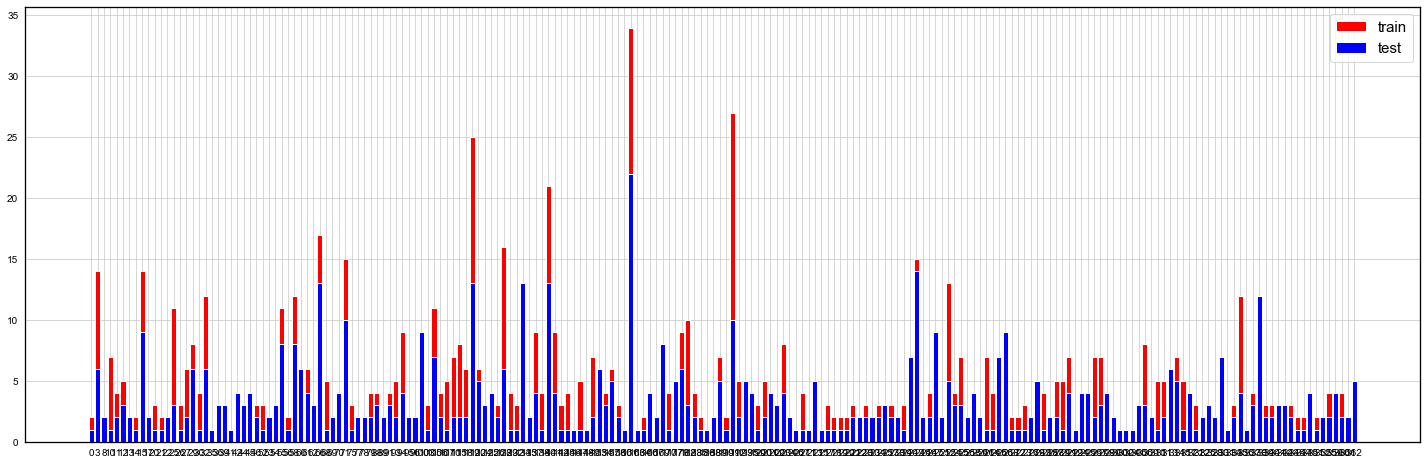

In [36]:
userid_interect = np.array(list(set(dat.userId[tr_indexes]).intersection(set(dat.userId[te_indexes]))))
tr_dict = dict(zip(userid_interect, [0 for i in userid_interect]))
te_dict = dict(zip(userid_interect, [0 for i in userid_interect]))
for user_id in tqdm_notebook(userid_interect):
    tr_dict[user_id] += (dat.userId[tr_indexes] == user_id).sum()
    te_dict[user_id] += (dat.userId[te_indexes] == user_id).sum()
tr_vals = list(tr_dict.values())
te_vals = list(te_dict.values())
plt.figure(figsize=(25, 8))
k = 200
plt.bar(np.arange(userid_interect.shape[0])[:k], tr_vals[:k], color='red', label='train')
plt.xticks(np.arange(userid_interect.shape[0])[:k], userid_interect[:k]);
plt.bar(np.arange(userid_interect.shape[0])[:k], te_vals[:k], color='blue', label='test')
plt.xticks(np.arange(userid_interect.shape[0])[:k], userid_interect[:k]);
plt.legend(fontsize=15);

Та же тенденция в scatterplot

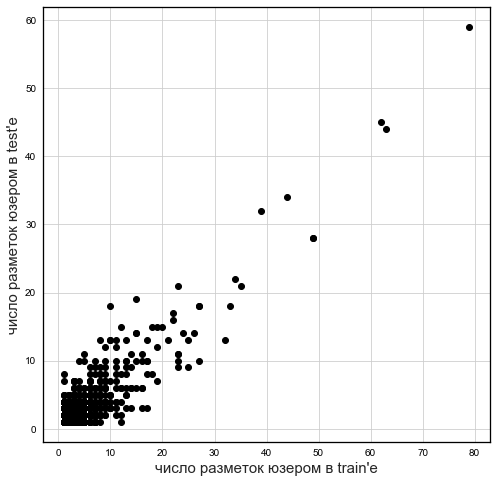

In [37]:
plt.scatter(tr_vals, te_vals);
plt.xlabel("число разметок юзером в train'e", fontsize=15);
plt.ylabel("число разметок юзером в test'e", fontsize=15);

Можно сделать вывод, что выборка разделена на треин и тест случайно

Построим матрицу, описывающую сколько юзеров разметило сколько картинок

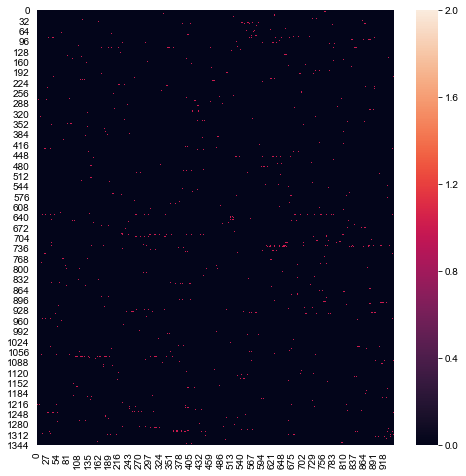

In [38]:
sns.heatmap(pd.crosstab(dat.userId[tr_indexes], dat.itemId[tr_indexes]).values);

Посмотрим на распеределение истинных координат точек, в зависимоти от размеченных координат

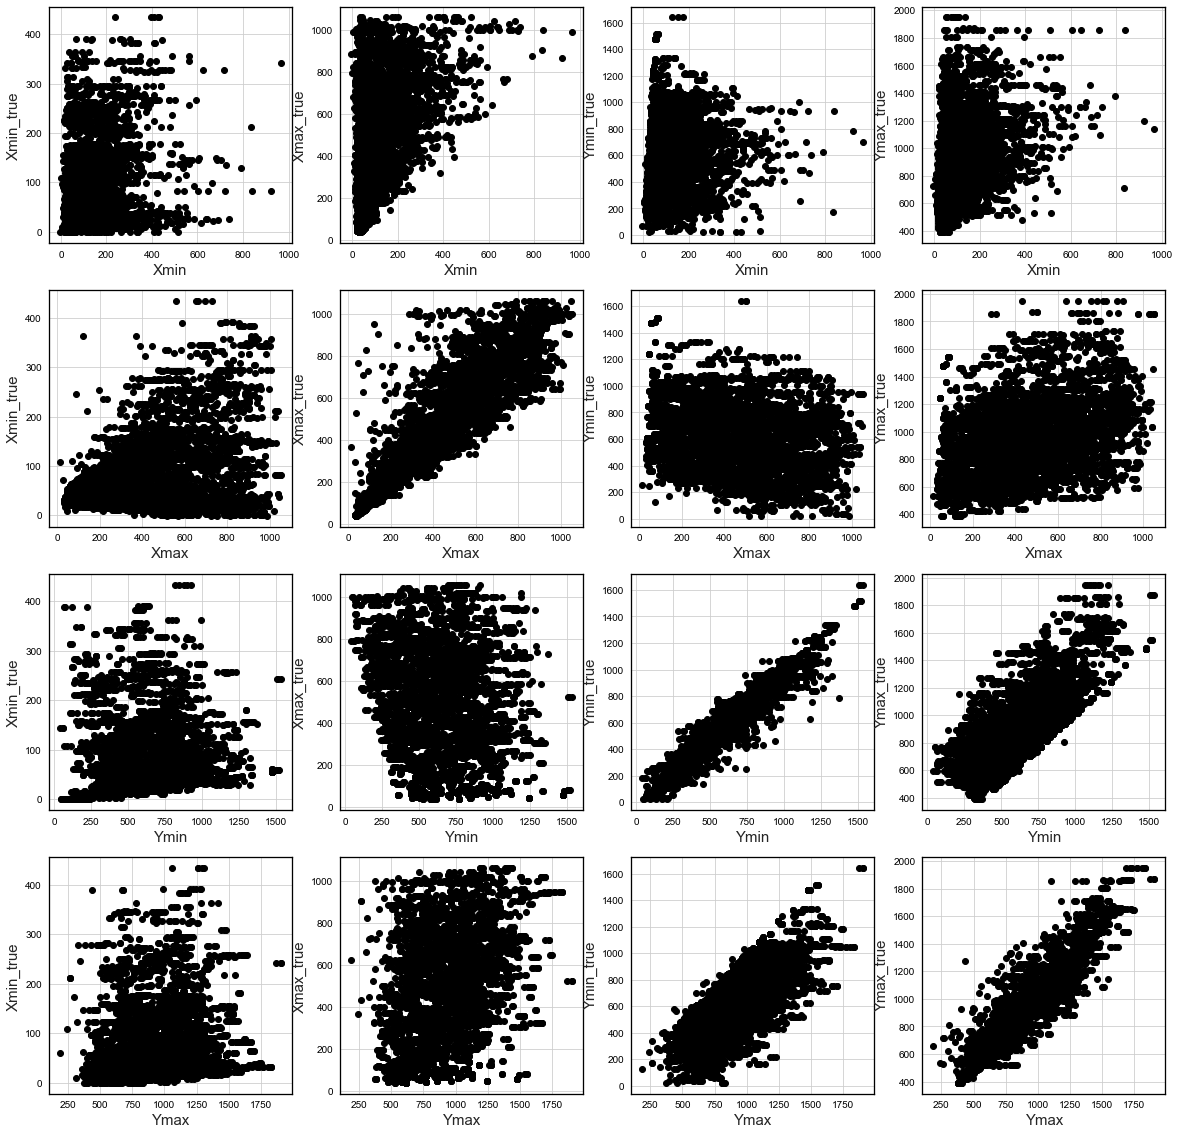

In [39]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
j = list(itertools.product([0, 1, 2, 3], [0, 1, 2, 3]))
k = 0
for taged_pos, true_pos in itertools.product(['Xmin', 'Xmax', 'Ymin', 'Ymax'], ['Xmin_true', 'Xmax_true', 'Ymin_true', 'Ymax_true']):
    ax[j[k][0], j[k][1]].scatter(dat[taged_pos][tr_indexes], dat[true_pos][tr_indexes])
    ax[j[k][0], j[k][1]].set_xlabel(taged_pos, fontsize=15);
    ax[j[k][0], j[k][1]].set_ylabel(true_pos, fontsize=15);
    k += 1

Эту зависимость можно так же изобразить в виде корреляционной матрицы

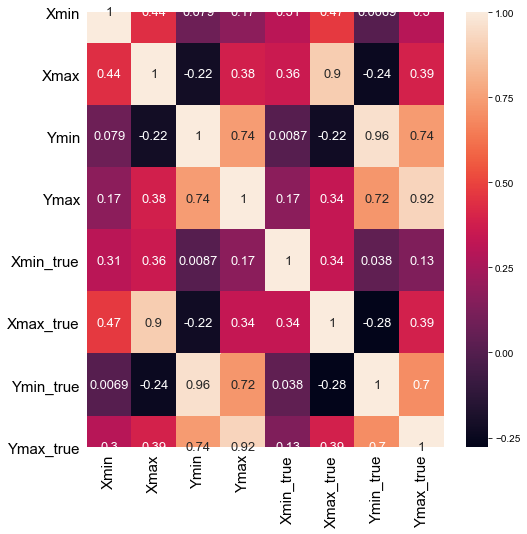

In [40]:
sns.heatmap(dat.loc[tr_indexes, ['Xmin', 'Xmax', 'Ymin', 'Ymax', 'Xmin_true', 'Xmax_true', 'Ymin_true', 'Ymax_true']].corr(), 
            annot=True, annot_kws={'size': 13});
plt.xticks(fontsize=15, rotation=90);
plt.yticks(fontsize=15, rotation=0);

Посмотрим на распределение истинных и размеченных координат

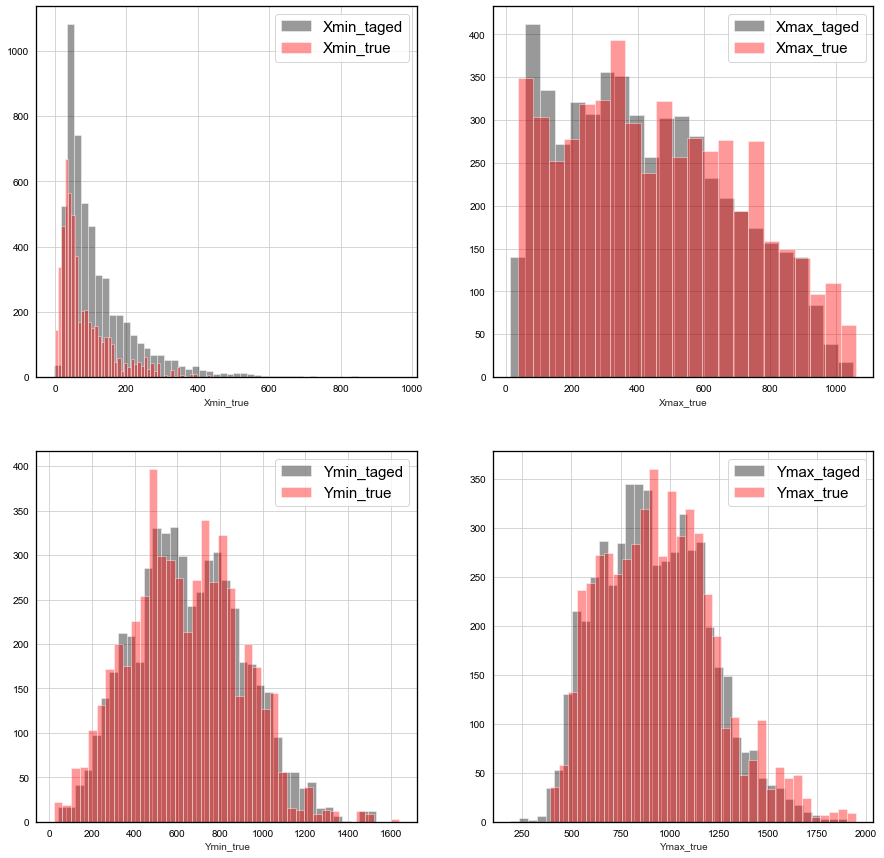

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15));
sns.distplot(dat.Xmin[tr_indexes], kde=False, ax=ax[0, 0], label='Xmin_taged');
sns.distplot(dat.Xmin_true[tr_indexes], kde=False, ax=ax[0, 0], label='Xmin_true');
ax[0, 0].legend(fontsize=15);

sns.distplot(dat.Xmax[tr_indexes], kde=False, ax=ax[0, 1], label='Xmax_taged');
sns.distplot(dat.Xmax_true[tr_indexes], kde=False, ax=ax[0, 1], label='Xmax_true');
ax[0, 1].legend(fontsize=15);

sns.distplot(dat.Ymin[tr_indexes], kde=False, ax=ax[1, 0], label='Ymin_taged');
sns.distplot(dat.Ymin_true[tr_indexes], kde=False, ax=ax[1, 0], label='Ymin_true');
ax[1, 0].legend(fontsize=15);

sns.distplot(dat.Ymax[tr_indexes], kde=False, ax=ax[1, 1], label='Ymax_taged');
sns.distplot(dat.Ymax_true[tr_indexes], kde=False, ax=ax[1, 1], label='Ymax_true');
ax[1, 1].legend(fontsize=15);

Посмотрим на пример разметок для одной картинки

507
0.6912555529576806
0.5344867898059388
0.8281505728314239
0.7277297170914192
0.7511495596601979


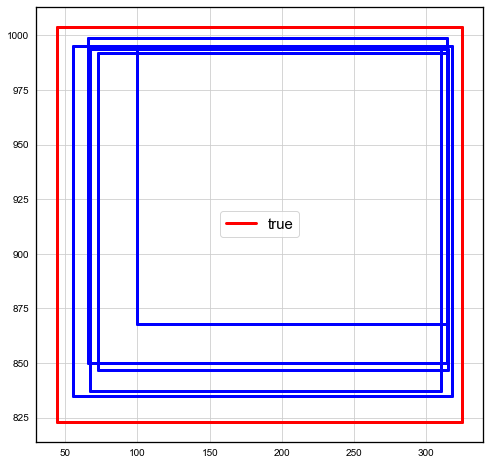

In [42]:
k = np.random.randint(dat.loc[tr_indexes].itemId.value_counts().shape[0])
# k = 106
print(k)
current_df = dat.loc[dat.itemId == dat.itemId[tr_indexes].value_counts().keys()[k]]
for i in range(min(5, current_df.shape[0])):
    print(current_df.iou.values[i])
#     print(current_df[['Xmin', 'Ymin', 'Xmax', 'Ymax']].values[i])
    plot_rectangle(current_df[['Xmin', 'Ymin', 'Xmax', 'Ymax']].values[i])
plot_rectangle(current_df[['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']].values[0], label='true', color='red');
# print('!!!')
# print(current_df[['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']].values[0])


Посмотрим на распределение метрики по юзерам (нужна переменная iou: см. Генерация признаков)

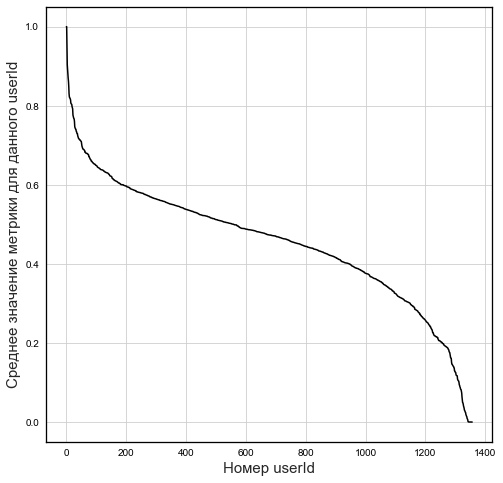

In [43]:
plt.plot(dat.groupby(['userId'])['iou'].mean().sort_values(ascending=False).values)
plt.xlabel('Номер userId', fontsize=15);
plt.ylabel('Среднее значение метрики для данного userId', fontsize=15);

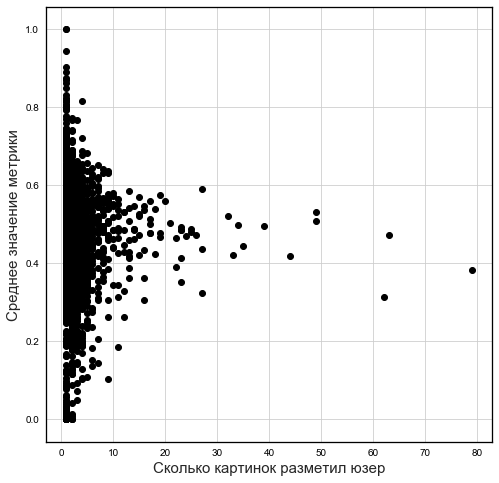

In [44]:
a = dat.groupby(['userId'])['userid_target_count', 'iou'].mean()
plt.scatter(a.userid_target_count, a.iou);
plt.xlabel('Сколько картинок разметил юзер', fontsize=15);
plt.ylabel('Среднее значение метрики', fontsize=15);

Посмотрим на распределение длин и высот рамок 

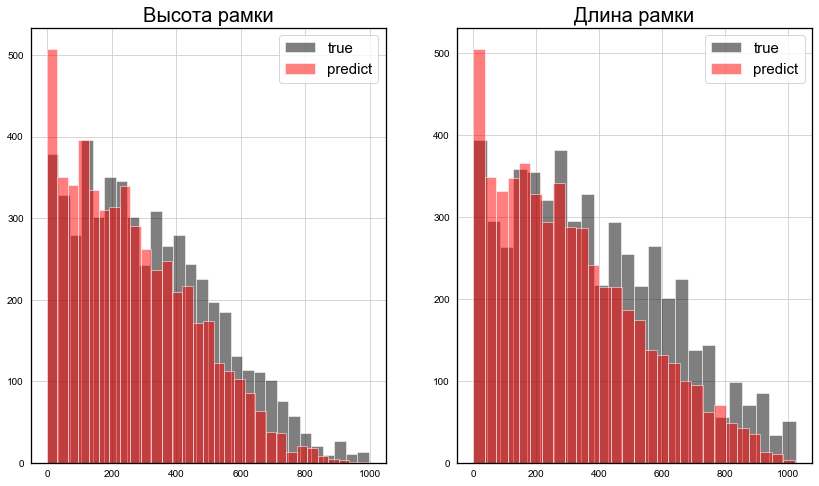

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8));
sns.distplot((dat.Ymax_true[tr_indexes] - dat.Ymin_true[tr_indexes]), kde=False, label='true', 
             ax=ax[0], hist_kws={'alpha': 0.5});
sns.distplot((dat.Ymax[tr_indexes] - dat.Ymin[tr_indexes]), kde=False, label='predict', 
             ax=ax[0], hist_kws={'alpha': 0.5});
ax[0].legend(fontsize=15);
ax[0].set_title('Высота рамки', fontsize=20);

sns.distplot((dat.Xmax_true[tr_indexes] - dat.Xmin_true[tr_indexes]), kde=False, label='true', 
             ax=ax[1], hist_kws={'alpha': 0.5});
sns.distplot((dat.Xmax[tr_indexes] - dat.Xmin[tr_indexes]), kde=False, label='predict', 
             ax=ax[1], hist_kws={'alpha': 0.5});
ax[1].legend(fontsize=15);
ax[1].set_title('Длина рамки', fontsize=20);

Посмотрим на распределение площадей картинок

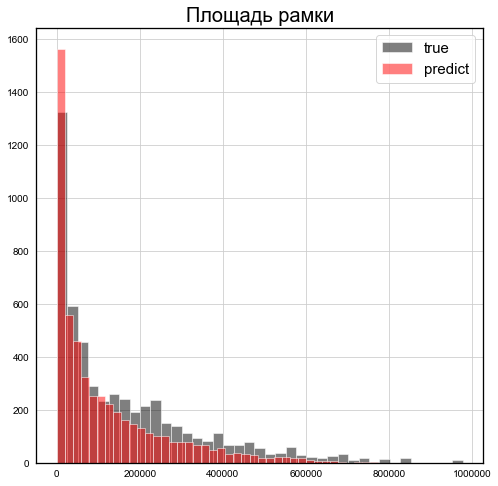

In [46]:
sns.distplot((dat.Ymax_true[tr_indexes] - dat.Ymin_true[tr_indexes])*
             (dat.Xmax_true[tr_indexes] - dat.Xmin_true[tr_indexes]), kde=False, label='true', 
             hist_kws={'alpha': 0.5});
sns.distplot((dat.Ymax[tr_indexes] - dat.Ymin[tr_indexes])*
             (dat.Xmax[tr_indexes] - dat.Xmin[tr_indexes]), kde=False, label='predict', 
             hist_kws={'alpha': 0.5});
plt.legend(fontsize=15);
plt.title('Площадь рамки', fontsize=20);

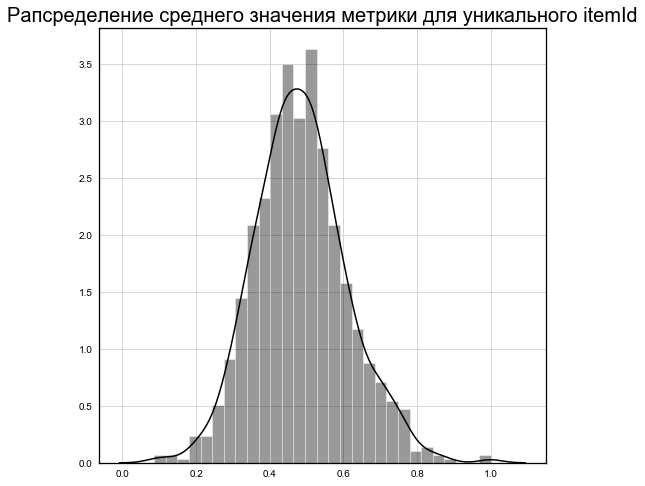

In [47]:
sns.distplot([user_item_array[:, j][user_item_array[:, j] > 0].mean() for j in range(user_item_array.shape[1])])
plt.title('Рапсределение среднего значения метрики для уникального itemId', fontsize=20);

Выберем оптимальный порог скора юзера с точки зрения числа таких юзеров в тесте

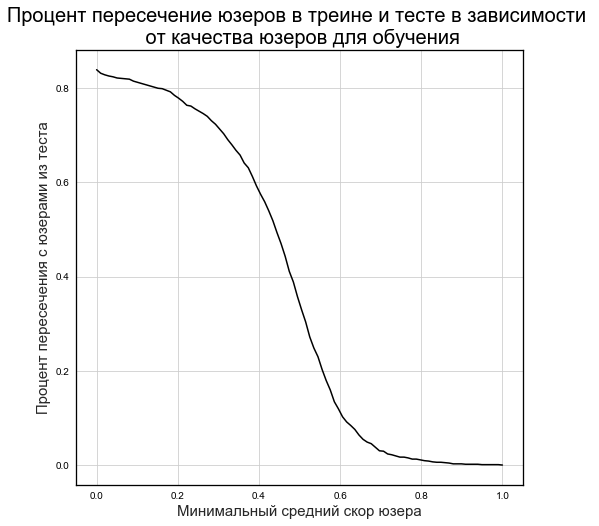

In [48]:
porog = np.linspace(0, 1, 100)
intersection_rate = [len(set(dat.userId[dat.mean_iou > i]).intersection(set(dat.userId[te_indexes])))/len(set(dat.userId[te_indexes])) for i in porog]
plt.plot(porog, intersection_rate);
plt.xlabel('Минимальный средний скор юзера', fontsize=15);
plt.ylabel('Процент пересечения с юзерами из теста', fontsize=15);
plt.title('Процент пересечение юзеров в треине и тесте в зависимости \n от качества юзеров для обучения', fontsize=20);

---
### Модели
---

1) Определение координат истинного прямоугольника

In [49]:
from sklearn.base import BaseEstimator 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

class MlBootcampRegressor(BaseEstimator):
    
    def __init__(self, regressor_model=CatBoostRegressor):
        self.regressor_model = regressor_model
        self.trained_models = None
        self.features_columns = None
        self.target_columns = None
        self.validation_score = None
        self.cat_features = None
        self.folds = {}
        
    def fit(self, X_y, features_columns, target_columns=['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], 
            model_parameters=None, 
            n_folds=None):
        self.features_columns = features_columns
        self.target_columns = target_columns
            
        if n_folds is not None:
            self.trained_models = []
            self.validation_score = []
            # Цикл по фолдам
            for fold in tqdm_notebook(range(n_folds)):
                # Создаём данные для обучения и для теста
                dat_val, dat_test = train_test_split(X_y, test_size=0.25, shuffle=True)
                self.folds.update({'train_' + str(fold + 1): dat_val, 'test_' + str(fold + 1): dat_test})
                current_fold_models_dict = {}
                predicts = [] 
                true_targets = []
                # Цикл по таргет колонкам
                for col in tqdm_notebook(target_columns):
                    cat_features = None
                    if model_parameters is not None:
                        if 'cat_features' in model_parameters:
                            self.cat_features = model_parameters['cat_features']
                            del model_parameters['cat_features']
                        local_model = self.regressor_model(**model_parameters)
                    else:
                        local_model = self.regressor_model
                    cross_val_score(local_model, X_y[features_columns], X_y[col], cv=KFold(n_folds))
                    if self.cat_features is not None:
                        local_model.fit(dat_val[features_columns].values, dat_val[col].values, 
                                        cat_features=self.cat_features)
                    else:
                        local_model.fit(dat_val[features_columns].values, dat_val[col].values)
                    current_fold_models_dict.update({col: local_model})
                    
                    current_col_predicitons = []
                    current_col_targets = []
                    for item_id in dat_test.itemId.value_counts().keys():
                        current_col_predicitons.append(current_fold_models_dict[col].predict(dat_test.loc[dat_test.itemId == item_id, 
                                                                                                         self.features_columns].values).mean())
                        current_col_targets.append(dat_test[col][dat_test.itemId == item_id].values[0])
                    predicts.append(current_col_predicitons)
                    true_targets.append(current_col_targets)    
           
                self.trained_models.append(current_fold_models_dict)
                true_targets = np.array(true_targets).T
                predicts = np.array(predicts).T
                
                current_fold_metric = iou_metric_matrix(predicts, true_targets)
                self.validation_score.append([np.mean(current_fold_metric), np.std(current_fold_metric)])
        else:
            self.trained_models = {}
            for col in tqdm_notebook(target_columns):
                cat_features = None
                if model_parameters is not None:
                    if 'cat_features' in model_parameters:
                        cat_features = model_parameters['cat_features']
                        del model_parameters['cat_features']
                    local_model = self.regressor_model(**model_parameters)
                else:
                    local_model = self.regressor_model
                if cat_features is not None:
                    local_model.fit(X_y[features_columns].values, X_y[col].values, 
                                    cat_features=cat_features)
                else:
                    local_model.fit(X_y[features_columns].values, X_y[col].values)
                self.trained_models.update({col: local_model})
                    
    def predict(self, X, item_ids_column):
        predictions = []
        for item_id in tqdm_notebook(item_ids_column):
            current_col_predicitons = []
            for col in self.target_columns:
                current_col_predicitons.append(self.trained_models[col].predict(X.loc[X.itemId == item_id, self.features_columns].values).mean())
            predictions.append(current_col_predicitons)
        return np.array(predictions)
    
    def eval_metric(self, predictions, targets):
        res = []
        for i in tqdm_notebook(range(len(targets))):
            res.append(iou_metric(predictions[i], targets[i]))
        return np.array(res)

In [228]:
features_columns = ['userId', 'Xmin', 'Ymin' , 'Xmax', 'Ymax',
       'userid_target_25', 'userid_target_50', 'userid_target_75',
       'userid_target_count', 'userid_target_max', 'userid_target_mean',
       'userid_target_min', 'userid_target_std'] + ['user_item_{}'.format(i+1) for i in range(user_item_array.shape[1])]
features_columns = ['Xmin', 'Ymin' , 'Xmax', 'Ymax'] + ['useritem_{}'.format(i+1) for i in range(user_item_array.shape[1])]

In [106]:
model = MlBootcampRegressor(regressor_model=KNeighborsRegressor)
model.fit(X_y=dat.loc[tr_indexes], features_columns=features_columns, 
          target_columns=['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], 
          model_parameters={'n_neighbors': 3}, n_folds=5)


2) Нейронка

In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from torch.utils.data import DataLoader

In [278]:
BATCH_SIZE = 10
dat_tr, dat_te = train_test_split(dat.loc[tr_indexes], test_size=0.15, shuffle=True)
train_loader = DataLoader(dat_tr[features_columns + target_cols].values, batch_size=BATCH_SIZE, shuffle=True) # создаём генеритор батчей для теина и теста
test_loader = DataLoader(dat_te[features_columns + target_cols].values, batch_size=BATCH_SIZE, shuffle=True)
INPUT_SIZE = len(features_columns)
LEN_TRAIN_BATCH = dat_tr.shape[0]/BATCH_SIZE
LEN_TEST_BATCH = dat_te.shape[0]/BATCH_SIZE

In [279]:
class MlbootNet(nn.Module):
    def __init__(self, layers, nonlinear=None):
        super(MlbootNet, self).__init__()
        self.lay_enc = nn.ModuleList([nn.Linear(i, j) for i, j in zip(layers, layers[1:])])
        if nonlinear is None:
            self.nonlin = nn.ModuleList([nn.ReLU() for i in range(len(self.lay_enc))])
        else:
            self.nonlin = nn.ModuleList([eval(i) for i in nonlinear])
        self.linear_enc = dict(zip(np.arange(0, 2*len(self.lay_enc), 2).astype(str), self.lay_enc))
        self.nonlinear = dict(zip(np.arange(1, 2*len(self.nonlin)-1, 2).astype(str), self.nonlin))
        self.ordered_layers = OrderedDict(sorted(dict(**self.linear_enc, **self.nonlinear).items(), key=lambda x: x[0]))
        self.out_layer = nn.Linear(layers[-1], 4)
        
    def forward(self, x):
        seq_layers = nn.Sequential(
            self.ordered_layers
        )
        out = seq_layers(x)
        out = self.out_layer(out)
        return out

In [281]:
model_neural = MlbootNet(layers=[len(features_columns), 100, 20, 10], nonlinear=None)
opt = optim.Adam(model_neural.parameters(), lr=1e-4)
criterion = nn.L1Loss(reduction='sum')

In [282]:
EPOCHS = 70
DEVICE = 'cpu'
model_neural.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
test_loss = []

for i in range(EPOCHS):
    model_neural.train()
    local_train_loss = 0
    st = time.perf_counter()
    for batch_ in train_loader:
        opt.zero_grad()
        x = batch_[:, :-4].float().to(DEVICE)
        y = batch_[:, -4:].float().to(DEVICE)
        y_pred = model_neural(x)
        loss = criterion(y_pred, y)
        local_train_loss += loss.item()/LEN_TRAIN_BATCH
        loss.backward()
        opt.step()
    train_loss.append(local_train_loss)
    
    with torch.no_grad():
        model_neural.eval()
        local_test_loss = 0
        for batch_ in test_loader:
            opt.zero_grad()
            x = batch_[:, :-4].float().to(DEVICE)
            y = batch_[:, -4:].float().to(DEVICE)
            y_pred = model_neural(x)
            loss = criterion(y_pred, y)
            local_test_loss += loss.item()/LEN_TEST_BATCH
        test_loss.append(local_test_loss)
        
#     y_pred_train_local = model_neural(torch.FloatTensor(X_y_tr['X']).cuda()).argmax(1).cpu().numpy()
#     y_pred_test_local = model_neural(torch.FloatTensor(X_y_te['X']).cuda()).argmax(1).cpu().numpy()

    if (i+1)%5 == 0:
        print('Epoch:', i+1, 
              'Train loss:', train_loss[-1], 'Test loss:', test_loss[-1],
              'Time:', time.perf_counter() - st)

Epoch: 5 Train loss: 4352.875224387626 Test loss: 4055.482669215972 Time: 2.7424274000004516
Epoch: 10 Train loss: 2347.1010002930143 Test loss: 2287.006781645929 Time: 2.608930499998678
Epoch: 15 Train loss: 2337.7415762334476 Test loss: 2312.838239538834 Time: 2.769186300000001
Epoch: 20 Train loss: 2330.453450843771 Test loss: 2272.508436719726 Time: 2.6442226999988634
Epoch: 25 Train loss: 2326.890146702897 Test loss: 2262.76883948013 Time: 2.6283318999994663
Epoch: 30 Train loss: 2322.7091038079916 Test loss: 2270.6461089440204 Time: 2.7155390000007174
Epoch: 35 Train loss: 2320.250478808424 Test loss: 2260.22913900654 Time: 2.8540262000005896
Epoch: 40 Train loss: 2318.9208563210914 Test loss: 2259.0357209204435 Time: 2.6714522000002034
Epoch: 45 Train loss: 2316.6998958419454 Test loss: 2260.1804609929723 Time: 2.630011999999624
Epoch: 50 Train loss: 2313.6719757833575 Test loss: 2264.3878577681226 Time: 2.5072039000006043
Epoch: 55 Train loss: 2313.244350238241 Test loss: 2257.

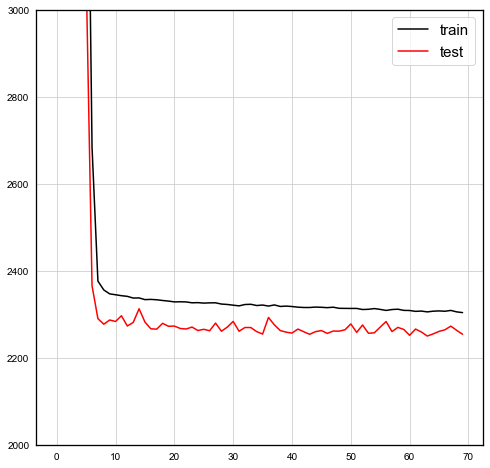

In [286]:
plt.plot(train_loss, label='train');
plt.plot(test_loss, label='test');
plt.legend(fontsize=15);
plt.ylim(2e3, 3e3);

In [287]:
model_neural.eval()
with torch.no_grad():
    y_pred = model_neural(torch.FloatTensor(dat.loc[tr_indexes, features_columns].values)).detach().numpy()
y_test = dat.loc[tr_indexes, target_cols].values

In [288]:
iou_metric_matrix(y_pred, y_test).mean()

0.5205105005131254

In [88]:
prediction = model.predict(dat.loc[tr_indexes], item_ids_column=set(dat.itemId[tr_indexes]))
true_target = []
metric_ = []
for i, true_ in enumerate(set(dat.itemId[tr_indexes])):
    true_target.append(dat.loc[dat.itemId == true_, ['Xmin_true',
       'Ymin_true', 'Xmax_true', 'Ymax_true']].values[0])
    metric_.append(iou_metric(prediction[i], true_target[-1]))
true_target = np.array(true_target)
metric_ = np.array(metric_)
print(metric_.mean())

In [194]:
current_fold_metric = []
for i, true_targets in tqdm_notebook(enumerate(set(dat.itemId[tr_indexes]))):
    current_fold_metric.append(iou_metric(preds[i], dat.loc[tr_indexes].loc[dat.itemId[tr_indexes] == true_targets, ['Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true']].values[0]))

In [61]:
cat_dict = {}
for col in tqdm_notebook(target_cols):
    cat = CatBoostRegressor()
    cat.fit(dat.loc[tr_indexes, ['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']].values, 
            dat[col][tr_indexes].values, verbose=False, cat_features=[0])
    cat_dict.update({'cat_' + col.replace('_true', ''): cat})

In [156]:
from sklearn.model_selection import train_test_split
for fold in tqdm_notebook(range(5)):
    dat_val, dat_test = train_test_split(dat.loc[tr_indexes], test_size=0.2, shuffle=True)
    cat_dict = {}
    for col in tqdm_notebook(target_cols):
        cat = CatBoostRegressor()
        cat.fit(dat_val[['userId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']], 
                dat_val[col], verbose=False, cat_features=[0])
        cat_dict.update({'cat_' + col.replace('_true', ''): cat})
#     predictions = 

KeyboardInterrupt: 

---
### Получение предсказаний для теста и сохранение ответа
---

In [86]:
submit = pd.read_csv(os.path.join(FILE_PATH, 'sample_submit_zero.csv'), header=None)
submit.shape

(630, 5)

In [87]:
for i, itemid in tqdm_notebook(enumerate(submit[0])):
    submit.iloc[i, 1] = model.trained_models['Xmin_true'].predict(dat.loc[dat.itemId == itemid, model.features_columns]).mean()
    submit.iloc[i, 2] = model.trained_models['Ymin_true'].predict(dat.loc[dat.itemId == itemid, model.features_columns]).mean()
    submit.iloc[i, 3] = model.trained_models['Xmax_true'].predict(dat.loc[dat.itemId == itemid, model.features_columns]).mean()
    submit.iloc[i, 4] = model.trained_models['Ymax_true'].predict(dat.loc[dat.itemId == itemid, model.features_columns]).mean()


In [90]:
submit.to_csv('/Users/tony/Desktop/ml_boot2.csv', index=False, header=False)